<img src="imagenes/iebs-logo.jpg" alt="Logo IEBS" align="center">
<br><br>
<h1><font color="#113D68" size=5>Impacto de las partículas contaminantes en la temperatura y calidad del aire en el Valle de Aburrá,  Antioquia-Colombia.</font></h1>

<h1><font color="#113D68" size=6>Transformaciones, analisis de los datos, modelos y conclusiones - Paso 4</font></h1>

<br><br>
<div style="text-align: right">
<font size=3>Laura López Bedoya</font><br>
<font size=3>Andrés Fernando Morales González</font><br>
<font size=3>Proyecto final del Postgrado en Data Science y Machine Learning</font><br>
<font size=3>2019 - 2020</font>
</div>

<a href="Paso 3 - Carga de la temperatura.html" target="_self">← Regresar al Paso 3 - Carga de la temperatura</a>

En este Notebook realizaremos todo el proceso de Data Science para obtener las conclusiones sobre el impacto que tiene el material particulado en la temperatura.

---
<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>

* [Carga de Datos](#section1)
* [Análisis descriptivo de los datos](#section2)
    * [Diagramas de caja](#section2.1)
    * [Rango de valores de las particulas](#section2.2)
* [Limpieza de Datos](#section3)
    * [Particulas con una calidad aceptable menor a 2.6](#section3.1)
    * [Particulas con calidad mala o no existentes](#section3.2)
    * [Limpieza de datos con calidad mayor a 2.6 (mala calidad)](#section3.3)
* [Entendimiento de los datos luego de la limpieza](#section4)
    * [Dispersión de los datos](#section4.1)
    * [Matríz de correlación](#section4.2) 
    * [Relación entre las particulas y la temperatura](#section4.3)
* [Implementación de los Modelos](#section5)
    * [Preparación de los datos de entrenamiento y prueba](#section5.1)
    * [Modelos supervisados: Arbol de desición, Random Forest, SVR y MLR](#section5.2)
    * [Red neuronal artificial (ANN)](#section5.3)
* [Modelos con variables categoricas](#section6)
    * [Regresión logistica, Arbol de desiciones, SVM y Random Forest](#section6.1)
    * [Red Neuronal Artificial (ANN)](#section6.2)

In [1]:
# Imports basicos
import pandas as pd # DataFrames
import pymysql # Base de datos
import os # Sistema operativo
import numpy as np # Operaciones matriciales y matematicas
import matplotlib.pyplot as plt # Graficas
import seaborn as sns # Mapas de calor y matriz de correlacion
import warnings # Warning

# Imports para modelos
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.svm import SVR # Support Vector Regression
from sklearn import linear_model # Regresion lineal
import tensorflow as tf

# Imports Modelos para Clasificacion
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Evaluación de modelos
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import statsmodels.api as sm # grafica QQ
import pylab as py # Grafica QQ

# Evaluación de modelo de clasificación
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

### Conexión a la Base de datos para obtener las estaciones


In [2]:
host = os.getenv('MYSQL_HOST')
port = os.getenv('MYSQL_PORT')
user = os.getenv('MYSQL_USER')
password = os.getenv('MYSQL_PASSWORD')
database = os.getenv('MYSQL_DATABASE')

<a id="section1"></a>
# <font color="#004D7F" size=6>Carga de Datos</font>
Según el analisis que realizamos identificamos que PM2.5, Ozono, CO, SO2 y NO2 son las variables que presentan en su totalidad mayor cantidad de datos pero solo se presentan en 1 estación por lo tanto revisamos otras combinaciones y la que da mejor resultado es **PM2.5, Ozono, NO2, NO y NOX** que se encuentran en 4 estaciones. También identificamos que de 855.120, 371.453 no tienen medición de la **temperatura** la cual es nuestra variable objetivo y 44.208 registros tienen la temperatura en 0 (debido a que son fechas extremas que no incluimos en la extracción de los datos). 

En esta carga de datos solo vamos a excluir algunos datos según lo mencionado anteriormente.

Para ver el analisis realizado en DataStudio dar click [aquí](https://datastudio.google.com/reporting/00117590-5ebb-4cef-96de-11658f627921)

Las estaciones que estan incluidas en el análisis se encuentran ubicadas así:

<img src="imagenes/estaciones_a_analizar.PNG" alt="Estaciones" align="center">


In [3]:
# Se consultan los datos que vamos a incluir en el analisis
connection = pymysql.connect(host, user, password, database)
datos = pd.read_sql("""select Fecha_Hora,
        pm25, calidad_pm25,
        no2, calidad_no2,
        ozono, calidad_ozono,
        no, calidad_no,
        nox, calidad_nox,
        temperatura
    from 
        CALIDAD_AIRE
    where
        temperatura != -9999 and temperatura != 0 and
        no2 != -9999 and ozono != -9999 and no != -9999 and
        nox != -9999 and pm25 != -9999;""", connection)
connection.close()

<a id="section2"></a>
# <font color="#004D7F" size=6>Análisis descriptivo de los datos </font> 

Las medidas de las particulas son las siguientes:
<img src="imagenes/medidas.PNG" alt="Estaciones" align="center">

In [4]:
datos.sample(10)

,Fecha_Hora,pm25,calidad_pm25,no2,calidad_no2,ozono,calidad_ozono,no,calidad_no,nox,calidad_nox,temperatura
9137,2018-04-28 13:00:00,35.0,1.0,36.2304,1.0,40.772400,2.2,8.85958,1.0,45.0900,1.0,25.2603
8661,2018-04-16 05:00:00,18.0,1.0,18.1124,1.0,0.672083,1.0,11.88890,1.0,29.9990,1.0,21.1935
21213,2019-02-16 18:00:00,33.0,1.0,42.0893,2.2,4.800000,1.0,32.76500,1.0,74.8543,1.0,28.6695
17521,2018-11-22 16:00:00,16.0,1.0,18.0760,1.0,15.500000,1.0,10.95860,1.0,29.0346,1.0,27.4242
17638,2018-11-26 02:00:00,12.0,1.0,15.2440,1.0,1.900000,1.0,35.49780,1.0,50.7418,1.0,21.2959
29947,2020-04-19 00:00:00,18.0,1.0,12.4641,1.0,16.900000,1.0,1.71960,1.0,14.1837,1.0,18.2038
2895,2017-12-13 15:00:00,18.0,1.0,36.8521,1.0,14.740100,1.0,38.77300,1.0,74.1264,1.0,26.6777
4434,2018-01-13 22:00:00,24.0,1.0,15.8729,1.0,2.237000,1.0,17.83300,1.0,33.7059,1.0,19.9792
5595,2018-02-08 18:00:00,30.0,1.0,33.5622,2.3,11.039000,1.0,18.00960,2.3,51.5743,2.3,27.1222
3094,2017-12-17 20:00:00,21.0,1.0,32.8299,1.0,5.220600,1.0,11.22490,1.0,44.0547,1.0,23.4753


In [5]:
# Tipo de datos
datos.dtypes

Fecha_Hora       datetime64[ns]
pm25                    float64
calidad_pm25            float64
no2                     float64
calidad_no2             float64
ozono                   float64
calidad_ozono           float64
no                      float64
calidad_no              float64
nox                     float64
calidad_nox             float64
temperatura             float64
dtype: object

In [6]:
# Tamaño del Dataset
print("El tamaño del dataset es " + str(datos.shape[0]))

El tamaño del dataset es 32098


In [7]:
# Describe
datos.describe()

,pm25,calidad_pm25,no2,calidad_no2,ozono,calidad_ozono,no,calidad_no,nox,calidad_nox,temperatura
count,32098.000000,32098.000000,32098.000000,32098.000000,32098.000000,32098.000000,32098.000000,32098.000000,32098.000000,32098.000000,32098.000000
mean,26.935619,1.169904,-4.163540,1.179355,13.803919,1.202069,-1.527193,1.229013,12.973423,1.199139,23.252272
std,80.116356,0.518216,432.375034,0.463721,23.135484,0.480851,433.036382,0.514107,433.978397,0.478794,3.270600
min,-15.000000,1.000000,-9993.000000,1.000000,-383.300000,1.000000,-9993.000000,1.000000,-9993.000000,1.000000,14.175500
25%,11.000000,1.000000,8.017950,1.000000,3.493375,1.000000,3.388875,1.000000,12.701800,1.000000,20.741200
50%,18.000000,1.000000,12.684750,1.000000,9.600000,1.000000,8.189305,1.000000,22.872400,1.000000,22.492000
75%,27.000000,1.000000,18.863225,1.000000,21.100000,1.000000,20.890075,1.000000,40.181450,1.000000,25.491625
max,995.000000,4.299500,94.375700,4.199200,2246.100000,3.100000,442.075000,4.199200,434.499000,4.199200,35.508700


In [8]:
# Verificación de datos faltantes
datosFaltantes = datos.shape[0] - datos.dropna().shape[0]
print("Hay {} datos faltantes".format(datosFaltantes))

Hay 0 datos faltantes


<a id="section2.1"></a>
## <font color="#004D7F" size=5>Diagramas de caja</font> 

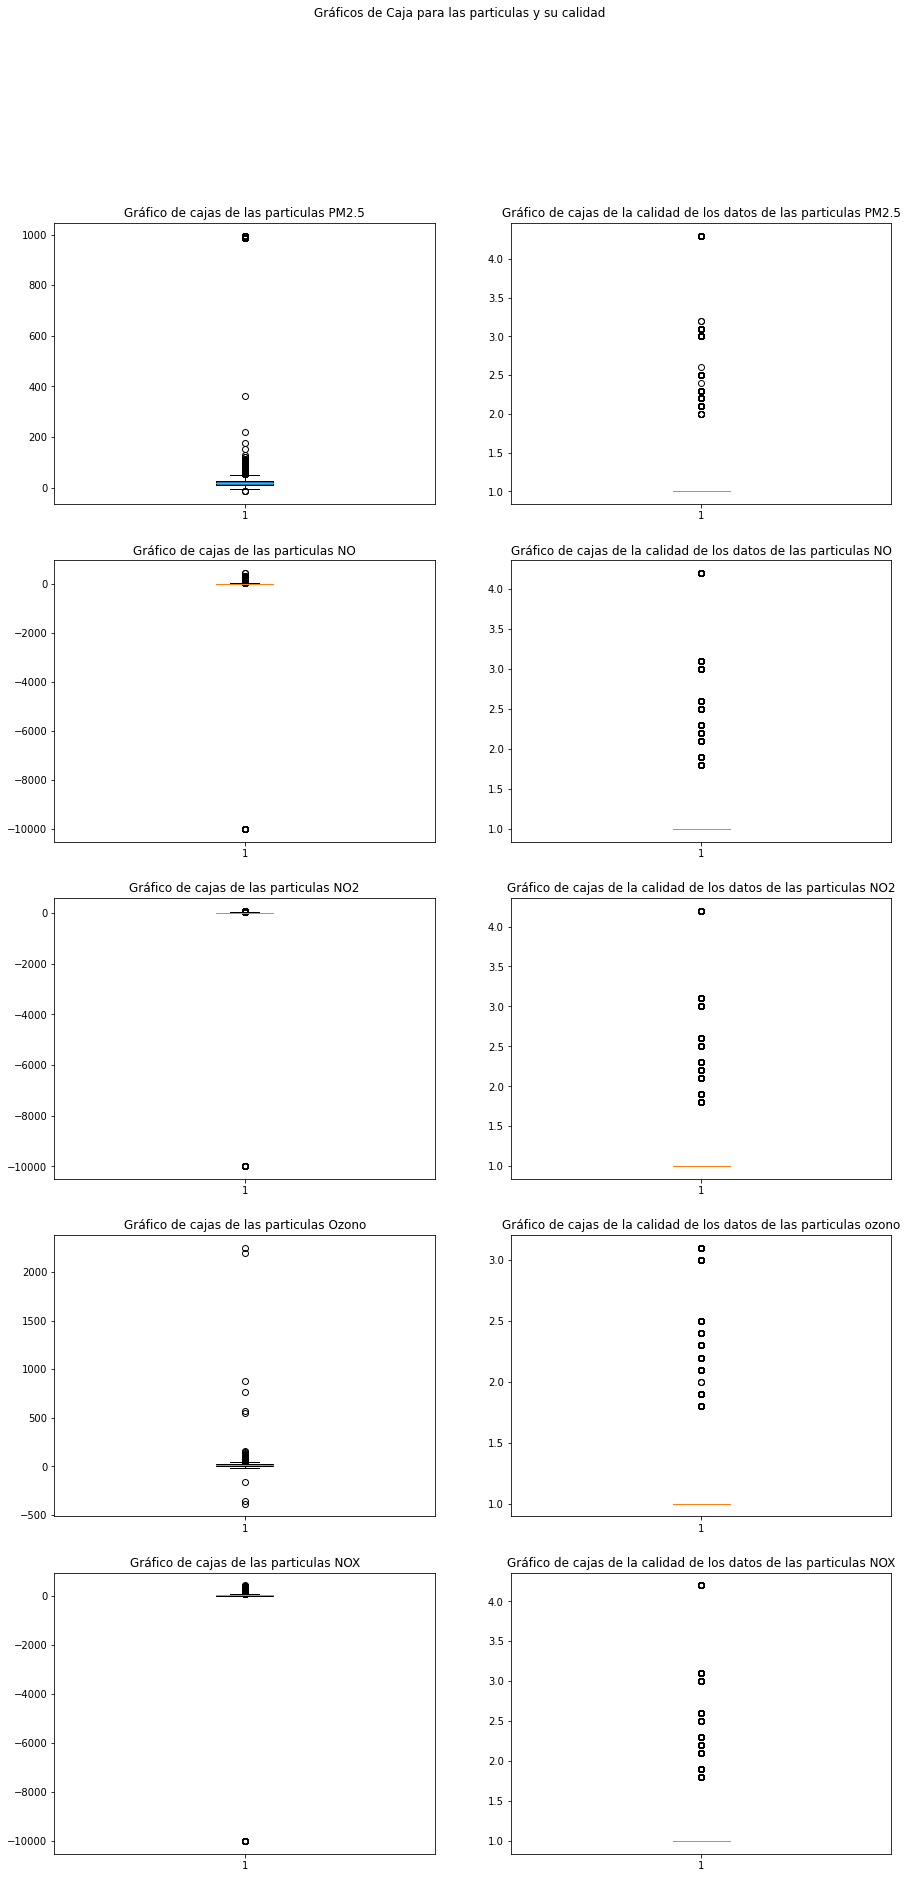

In [9]:
plt.figure(figsize=(15, 30))

# PM2.5
plt.subplot(5,2,1)
plt.boxplot(datos["pm25"],vert=True,patch_artist=True);
plt.title("Gráfico de cajas de las particulas PM2.5");

plt.subplot(5,2,2)
plt.boxplot(datos["calidad_pm25"],vert=True,patch_artist=True);
plt.title("Gráfico de cajas de la calidad de los datos de las particulas PM2.5");

# NO
plt.subplot(5,2,3)
plt.boxplot(datos["no"],vert=True,patch_artist=True);
plt.title("Gráfico de cajas de las particulas NO");

plt.subplot(5,2,4)
plt.boxplot(datos["calidad_no"],vert=True,patch_artist=True);
plt.title("Gráfico de cajas de la calidad de los datos de las particulas NO");

# NO2
plt.subplot(5,2,5)
plt.boxplot(datos["no2"],vert=True,patch_artist=True);
plt.title("Gráfico de cajas de las particulas NO2");

plt.subplot(5,2,6)
plt.boxplot(datos["calidad_no2"],vert=True,patch_artist=True);
plt.title("Gráfico de cajas de la calidad de los datos de las particulas NO2");

# Ozono
plt.subplot(5,2,7)
plt.boxplot(datos["ozono"],vert=True,patch_artist=True);
plt.title("Gráfico de cajas de las particulas Ozono");

plt.subplot(5,2,8)
plt.boxplot(datos["calidad_ozono"],vert=True,patch_artist=True);
plt.title("Gráfico de cajas de la calidad de los datos de las particulas ozono");

# NOX
plt.subplot(5,2,9)
plt.boxplot(datos["nox"],vert=True,patch_artist=True);
plt.title("Gráfico de cajas de las particulas NOX");

plt.subplot(5,2,10)
plt.boxplot(datos["calidad_nox"],vert=True,patch_artist=True);
plt.title("Gráfico de cajas de la calidad de los datos de las particulas NOX");

plt.suptitle('Gráficos de Caja para las particulas y su calidad')
plt.show()

<a id="section2.2"></a>
## <font color="#004D7F" size=5>Rango de valores de las particulas</font> 

Con los diagramas de caja podemos observar que los datos están con bastantes outliers, los cuales si nos los tratamos correctamente dañaran nuestro modelo. De estás graficas podemos decir que:

- el 50% de los datos rondan en valores cercanos a 0 (-100 y 100) en μg/m3 para el PM2.5 y ppb para las demas particulas

- Según el IDEAM (Intituto de Hidrología, Meteorología y Estudios Ambientales) los rango de las particulas son las siguientes:
<img src="imagenes/IDEAM_medidas2.png" alt="Estaciones" align="center">

Con el factor de conversión del 1ppm = 1000ppb tenemos que: 
- 0 μg/m3 <= *PM2.5* < 500.4 μg/m3 
- 0 ppb <= *NO2* < 2040 ppb
- 0 ppb <= *NO* < 2040 ppb
- 0 ppb <= *NOX* < 2040 ppb
- 0 ppb <= *Ozono* < 604 ppb

<a id="section3"></a>
# <font color="#004D7F" size=6>Limpieza de Datos</font> 
Debido a que se presentan outliers o datos atipicos debemos proceder a analizar si calidad y si se pueden reemplazar por la media. Nos guiaremos en la calidad del dato para hacer este limpieza.

Nos vamos a basar en la siguiente tabla de la calidad del dato para la limpieza:
<img src="imagenes/calidad_datos_medicion.PNG" alt="Estaciones" align="center">

<a id="section3.1"></a>
## <font color="#004D7F" size=5>Particulas con una calidad aceptable menor a 2.6</font> 

In [10]:
calidad = 2.6
pm25Buenos = datos[datos["calidad_pm25"] < calidad]
no2Buenos = datos[datos["calidad_no2"] < calidad]
ozonoBuenos = datos[datos["calidad_ozono"] < calidad]
noBuenos = datos[datos["calidad_no"] < calidad]
noxBuenos = datos[datos["calidad_nox"] < calidad]

print("Material particulado menor a 2.5 micras con una calidad aceptable (incluyendo los dudosos)")
print(pm25Buenos["pm25"].describe())

print("\nDióxido de Nitrogeno con una calidad aceptable (incluyendo los dudosos)")
print(no2Buenos["no2"].describe())

print("\nOzono con una calidad aceptable (incluyendo los dudosos)")
print(ozonoBuenos["ozono"].describe())

print("\nMonóxido de Nitrogeno con una calidad aceptable (incluyendo los dudosos)")
print(noBuenos["no"].describe())

print("\nÓxidos de Nitrogeno con una calidad aceptable (incluyendo los dudosos)")
print(noxBuenos["nox"].describe())

Material particulado menor a 2.5 micras con una calidad aceptable (incluyendo los dudosos)
count    30962.000000
mean        20.818019
std         13.308470
min          0.000000
25%         11.000000
50%         18.000000
75%         27.000000
max        128.000000
Name: pm25, dtype: float64

Dióxido de Nitrogeno con una calidad aceptable (incluyendo los dudosos)
count    31111.000000
mean        14.525961
std          9.020804
min          0.000000
25%          8.130380
50%         12.771600
75%         18.858550
max         94.375700
Name: no2, dtype: float64

Ozono con una calidad aceptable (incluyendo los dudosos)
count    31322.000000
mean        13.736053
std         12.575447
min          0.000000
25%          3.558365
50%          9.900000
75%         21.300000
max        119.403000
Name: ozono, dtype: float64

Monóxido de Nitrogeno con una calidad aceptable (incluyendo los dudosos)
count    31136.000000
mean        17.192831
std         23.110381
min          0.000000
25%    

Se encuentra que la gran cantidad de datos esta dentro de un rango aceptable de calidad. El tamaño del dataset es **32098** y en promedio 31170 son aceptables.

<a id="section3.2"></a>
## <font color="#004D7F" size=5>Particulas con calidad mala o no existentes</font> 
Debemos de analizar el estado de los datos donde la calidad es mala, es decir mayor a 2.6 para reemplazarlos por la media y que no influyan en nuestro modelo.

In [11]:
pm25Malos = datos[datos["calidad_pm25"] >= calidad]
no2Malos = datos[datos["calidad_no2"] >= calidad]
ozonoMalos = datos[datos["calidad_ozono"] >= calidad]
noMalos = datos[datos["calidad_no"] >= calidad]
noxMalos = datos[datos["calidad_nox"] >= calidad]

print("Matiral particulado menor a 2.5 micras con mala calidad")
print(pm25Malos["pm25"].describe())

print("\nDióxido de Nitrogeno con mala calidad")
print(no2Malos["no2"].describe())

print("\nOzono con mala calidad")
print(ozonoMalos["ozono"].describe())

print("\nMonóxido de Nitrogeno con mala calidad")
print(noMalos["no"].describe())

print("\nÓxidos de Nitrogeno con mala calidad")
print(noxMalos["nox"].describe())

Matiral particulado menor a 2.5 micras con mala calidad
count    1136.000000
mean      193.672535
std       384.494863
min       -15.000000
25%         2.000000
50%         7.000000
75%        18.250000
max       995.000000
Name: pm25, dtype: float64

Dióxido de Nitrogeno con mala calidad
count     987.000000
mean     -593.270995
std      2392.631706
min     -9993.000000
25%         3.555600
50%         8.371830
75%        19.173950
max        72.783700
Name: no2, dtype: float64

Ozono con mala calidad
count     776.000000
mean       16.543230
std       125.573837
min      -383.300000
25%         1.900000
50%         3.300000
75%         7.200000
max      2246.100000
Name: ozono, dtype: float64

Monóxido de Nitrogeno con mala calidad
count     962.000000
mean     -607.417683
std      2422.181620
min     -9993.000000
25%        -0.291175
50%         0.490100
75%        14.524750
max       442.075000
Name: no, dtype: float64

Óxidos de Nitrogeno con mala calidad
count     987.000000
mean

<a id="section3.3"></a>
## <font color="#004D7F" size=5>Limpieza de datos con calidad mayor a 2.6 (mala calidad)</font>
Comparando los datos buenos con los datos malos se observa que la desviación estandar y la media se ven afectas por los limites y los datos erroneos. Tambien se observan valores menores a 0 lo que es totalmente incorrecto. Vamos a reemplazar cada dato malo por la media de los datos buenos de la siguiente forma:

In [12]:
totalRegistros = datos.shape[0]

pm25Porcentaje = pm25Malos.shape[0] * 100 / totalRegistros
no2Porcentaje = no2Malos.shape[0] * 100 / totalRegistros
ozonoPorcentaje = ozonoMalos.shape[0] * 100 / totalRegistros
noPorcentaje = noMalos.shape[0] * 100 / totalRegistros
noxPorcentaje = noxMalos.shape[0] * 100 / totalRegistros

print("El {:.2f}% de PM2.5 va a ser reemplazado por {:.2f} μg/m3".format(pm25Porcentaje, pm25Buenos["pm25"].mean()))
print("El {:.2f}% de NO2 va a ser reemplazado por {:.2f} ppb".format(no2Porcentaje, no2Buenos["no2"].mean()))
print("El {:.2f}% de Ozono va a ser reemplazado por {:.2f} ppb".format(ozonoPorcentaje, ozonoBuenos["ozono"].mean()))
print("El {:.2f}% de NO va a ser reemplazado por {:.2f} ppb".format(noPorcentaje, noBuenos["no"].mean()))
print("El {:.2f}% de NOX va a ser reemplazado por {:.2f} ppb".format(noxPorcentaje, noxBuenos["nox"].mean()))


El 3.54% de PM2.5 va a ser reemplazado por 20.82 μg/m3
El 3.07% de NO2 va a ser reemplazado por 14.53 ppb
El 2.42% de Ozono va a ser reemplazado por 13.74 ppb
El 3.00% de NO va a ser reemplazado por 17.19 ppb
El 3.07% de NOX va a ser reemplazado por 31.65 ppb


In [13]:
warnings.filterwarnings('ignore')

mediaPm25 = pm25Buenos["pm25"].mean()
for i in list(pm25Malos.index):
    datos["pm25"][i] = mediaPm25

mediaNo2 = no2Buenos["no2"].mean()
for i in list(no2Malos.index):
    datos["no2"][i] = mediaNo2

mediaOzono = ozonoBuenos["ozono"].mean()
for i in list(ozonoMalos.index):
    datos["ozono"][i] = mediaOzono
    
mediaNo = noBuenos["no"].mean()
for i in list(noMalos.index):
    datos["no"][i] = mediaNo

mediaNox = noxBuenos["nox"].mean()
for i in list(noxMalos.index):
    datos["nox"][i] = mediaNox
    

<a id="section4"></a>
# <font color="#004D7F" size=6>Entendimiento de los datos luego de la limpieza</font>
En esta sección podemos observar como quedaron nuestros datos luego de ser limpiados y transformados. A diferencia del estado inicial de los datos se observa que los minimos, maximos y la media son mas reales y acordes a los limites establecidos de los datos.

In [14]:
datos.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pm25,32098.0,20.818019,13.070837,0.0000,11.000000,19.000000,27.000000,128.0000
calidad_pm25,32098.0,1.169904,0.518216,1.0000,1.000000,1.000000,1.000000,4.2995
no2,32098.0,14.525961,8.881023,0.0000,8.283775,13.087100,18.623750,94.3757
calidad_no2,32098.0,1.179355,0.463721,1.0000,1.000000,1.000000,1.000000,4.1992
ozono,32098.0,13.736053,12.422501,0.0000,3.618112,10.372500,21.000000,119.4030
calidad_ozono,32098.0,1.202069,0.480851,1.0000,1.000000,1.000000,1.000000,3.1000
no,32098.0,17.192831,22.761418,0.0000,3.638825,8.762465,20.364775,345.0050
calidad_no,32098.0,1.229013,0.514107,1.0000,1.000000,1.000000,1.000000,4.1992
nox,32098.0,31.647010,27.223627,0.0000,13.262075,23.972400,39.499600,283.8110
calidad_nox,32098.0,1.199139,0.478794,1.0000,1.000000,1.000000,1.000000,4.1992


<a id="section4.1"></a>
## <font color="#004D7F" size=5>Dispersión de los datos</font>

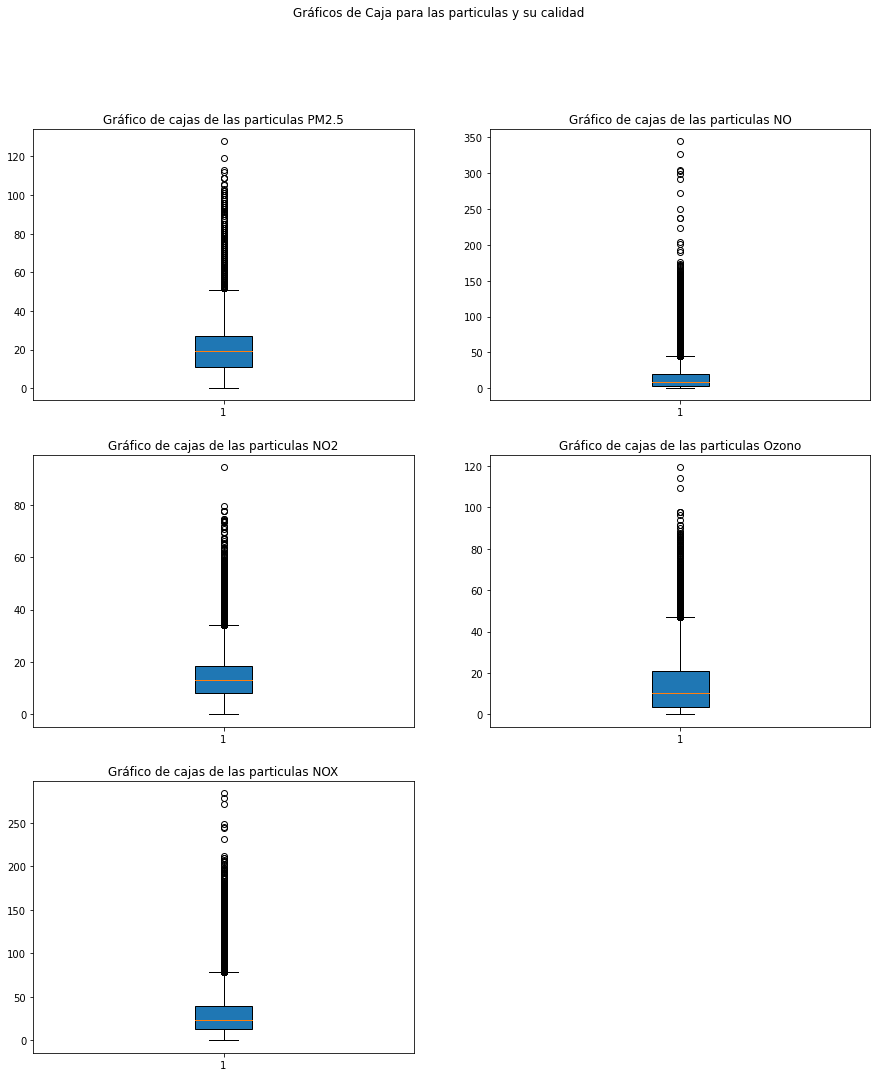

In [15]:
plt.figure(figsize=(15, 17))

# PM2.5
plt.subplot(3,2,1)
plt.boxplot(datos["pm25"],vert=True,patch_artist=True);
plt.title("Gráfico de cajas de las particulas PM2.5");

# NO
plt.subplot(3,2,2)
plt.boxplot(datos["no"],vert=True,patch_artist=True);
plt.title("Gráfico de cajas de las particulas NO");

# NO2
plt.subplot(3,2,3)
plt.boxplot(datos["no2"],vert=True,patch_artist=True);
plt.title("Gráfico de cajas de las particulas NO2");

# Ozono
plt.subplot(3,2,4)
plt.boxplot(datos["ozono"],vert=True,patch_artist=True);
plt.title("Gráfico de cajas de las particulas Ozono");

# NOX
plt.subplot(3,2,5)
plt.boxplot(datos["nox"],vert=True,patch_artist=True);
plt.title("Gráfico de cajas de las particulas NOX");

plt.suptitle('Gráficos de Caja para las particulas y su calidad')
plt.show()

Luego de la limpieza observamos que los datos tienden a ser mas estables sin embargo se muestran algunos como outliers.No lo son debido a que estan dentro de los limites permitidos.

<a id="section4.2"></a>
## <font color="#004D7F" size=5>Matríz de Correlación</font>

Para ver como se correlacionan las variables entre si vamos a usar SNS. Vamos a agregar la hora para efectos de analisis.

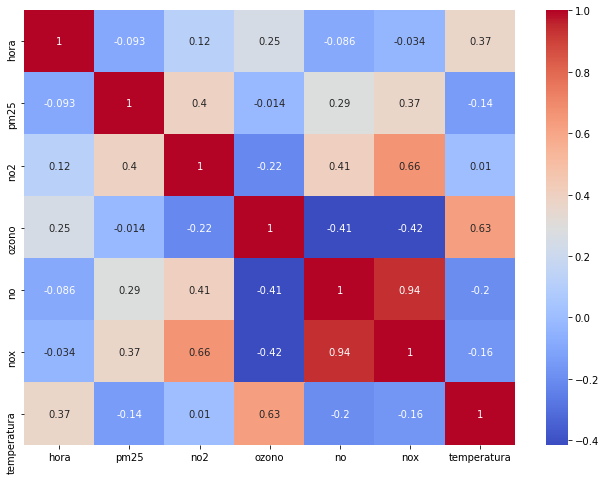

In [16]:
datos["hora"] = datos["Fecha_Hora"].dt.hour
plt.figure(figsize=(11, 8))
sns.heatmap(datos[["hora","pm25","no2","ozono","no","nox","temperatura"]].corr(),cmap='coolwarm',annot=True)

<a id="section4.3"></a>
## <font color="#004D7F" size=5>Relación entre las particulas y la temperatura</font>

Text(0.5, 1.0, 'Grafica de PM2.5 vs Temperatura')

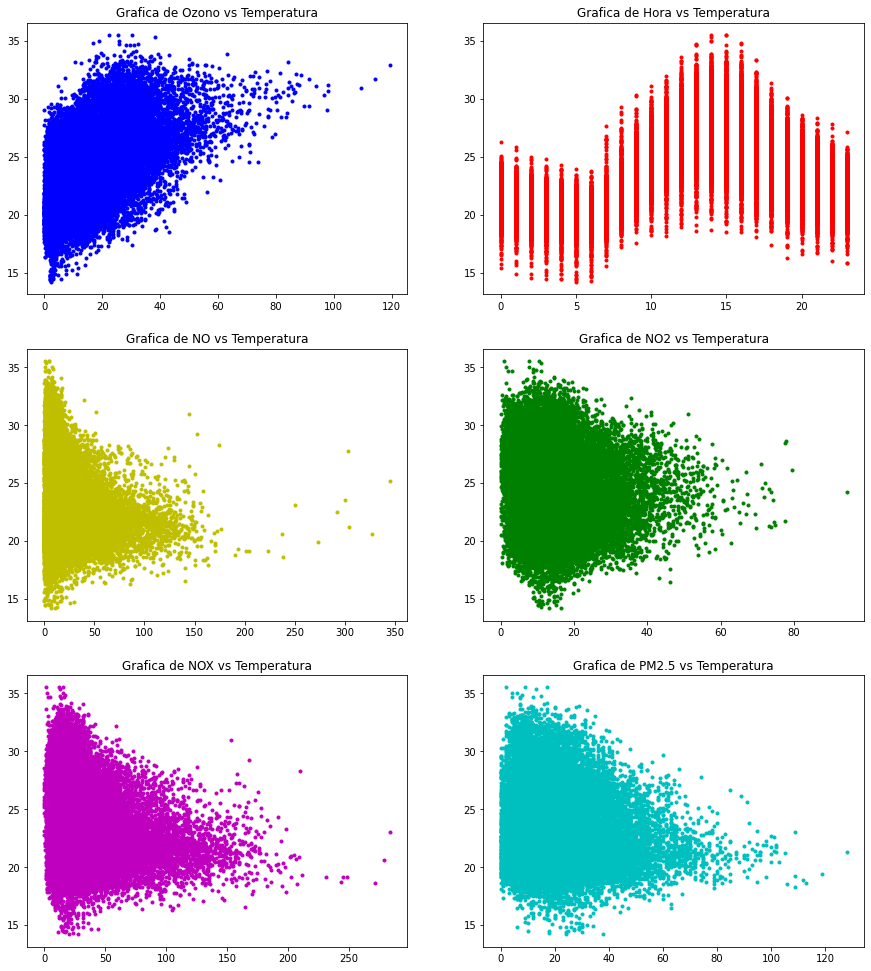

In [17]:
plt.figure(figsize=(15, 17))

plt.subplot(3,2,1)
plt.plot(datos['ozono'], datos['temperatura'],'b.')
plt.title('Grafica de Ozono vs Temperatura')

plt.subplot(3,2,2)
plt.plot(datos['hora'], datos['temperatura'],'r.')
plt.title('Grafica de Hora vs Temperatura')

plt.subplot(3,2,3)
plt.plot(datos['no'], datos['temperatura'],'y.')
plt.title('Grafica de NO vs Temperatura')

plt.subplot(3,2,4)
plt.plot(datos['no2'], datos['temperatura'],'g.')
plt.title('Grafica de NO2 vs Temperatura')

plt.subplot(3,2,5)
plt.plot(datos['nox'], datos['temperatura'],'m.')
plt.title('Grafica de NOX vs Temperatura')

plt.subplot(3,2,6)
plt.plot(datos['pm25'], datos['temperatura'],'c.')
plt.title('Grafica de PM2.5 vs Temperatura')

El Ozono presenta una correlación casi lineal con la temperatura y es mayor que la correlación entre la temperatura y la hora. Basados en la visualización en Data Studio intuimos que la correlación entre la hora y la temperatura iba a ser mayor. 

Pensamos que la correlación entre la hora y la temperatura es menor porque la temperatura varia dependiendo de la epoca del año.

<a id="section5"></a>
# <font color="#004D7F" size=6>Implementación de los Modelos</font>
A continuación se construyen los modelos, se entrenan y se evaluan para determinar cual es el que mejor predice la temperatura usando las particulas y la hora.

In [18]:
# Se guarda el dataframe para evitar la consulta nuevamente y la transformacion
datos.to_csv(r'datos_modelo.csv', index = False, encoding='utf-8')

<a id="section5.1"></a>
## <font color="#004D7F" size=5>Preparación de los datos de entrenamiento y prueba</font>

In [20]:
datosTest = pd.read_csv("datos_modelo.csv")

x_train, x_test, y_train, y_test = train_test_split(datosTest[['pm25', 'no2',  'ozono', 'no', 'hora']], datosTest['temperatura'], test_size=0.25)
print('Datos de entrenamiento X: \n {} \n'.format(x_train.head()))
print('Datos de prueba X: \n {} \n'.format(x_test.head()))
print('Datos de entrenamiento Y: \n {} \n'.format(y_train.head()))
print('Datos de prueba Y: \n {} \n'.format(y_test.head()))

Datos de entrenamiento X: 
         pm25      no2      ozono        no  hora
4018    12.0   4.8865  36.500000   3.23060    14
6805    38.0  18.7511  18.738100   3.98833    19
6828   109.0  17.2165   2.728000  26.04670     7
21629   35.0  23.5611  22.300000  10.51630    12
9237    19.0  20.2778  13.736053  31.70350    21 

Datos de prueba X: 
        pm25      no2  ozono       no  hora
29404  16.0   2.8537   32.1   1.3461    10
27883   7.0  11.4503   10.4   3.8821    18
23013  13.0  11.5648   11.2   1.3393     2
20013  21.0   9.1108    9.4   5.6255     0
28128  58.0  20.4655    4.4  18.9147     6 

Datos de entrenamiento Y: 
 4018     25.0680
6805     25.2037
6828     19.2145
21629    26.0620
9237     23.1795
Name: temperatura, dtype: float64 

Datos de prueba Y: 
 29404    27.3250
27883    22.3102
23013    20.5400
20013    20.2078
28128    21.0143
Name: temperatura, dtype: float64 



<a id="section5.2"></a>
## <font color="#004D7F" size=5>Modelos supervisados: Arbol de desición, Random Forest, SVR y MLR</font>
Escogimos estos modelos de Machine Learning debido a que tenemos varias variables de entrada y númericas al igual que la variable objetivo. 

Nos basamos en el estado del arte para la elección de los modelos.  

Método:  1 DecisionTreeRegressor(max_depth=7, random_state=1)
El error cuadrático medio es: 1.9521091582598893
r2_score:  0.6403776055288104
Cross-Validation:  0.8037698290350495




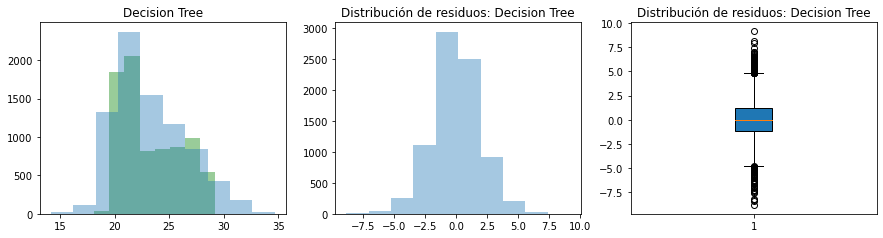

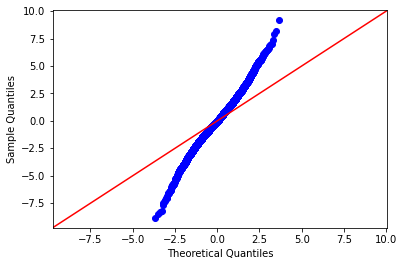

Método:  2 RandomForestRegressor(max_depth=14, random_state=1)
El error cuadrático medio es: 1.8256899101909096
r2_score:  0.6854479200227914
Cross-Validation:  0.8309279782829948




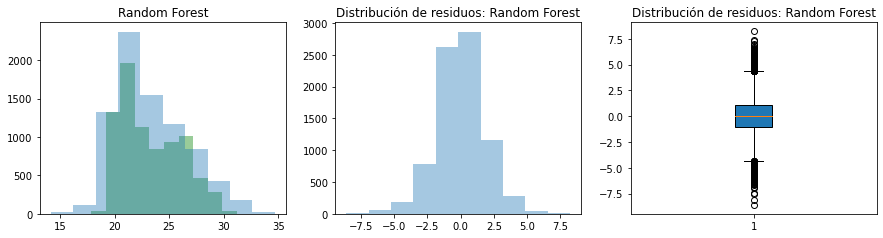

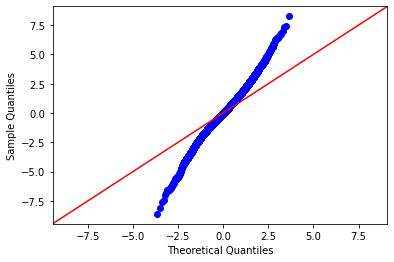

Método:  3 SVR()
El error cuadrático medio es: 1.9934352738324426
r2_score:  0.624990035058339
Cross-Validation:  0.7948225913767707




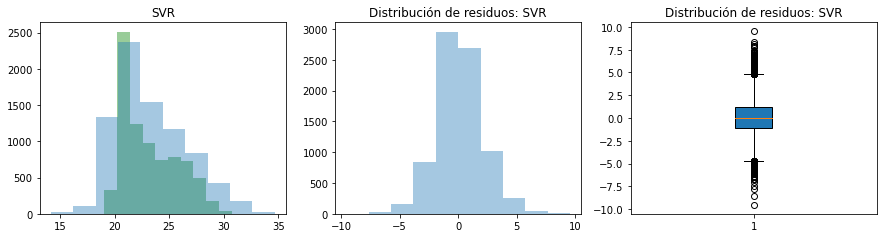

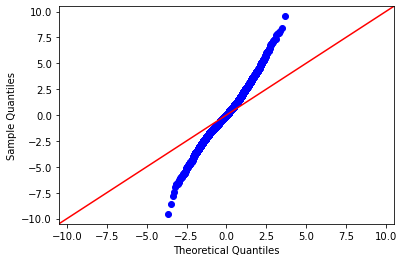

Método:  4 LinearRegression()
El error cuadrático medio es: 2.352525527176224
r2_score:  0.4777154008601714
Cross-Validation:  0.6991478618173078




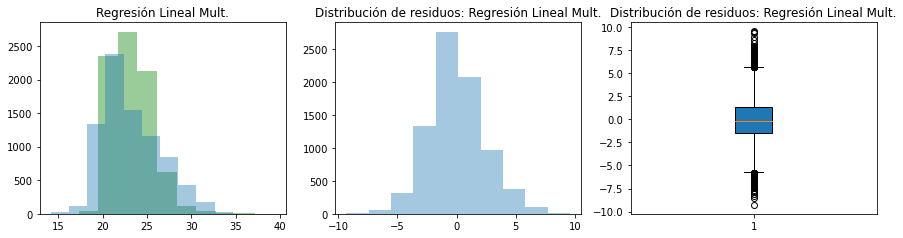

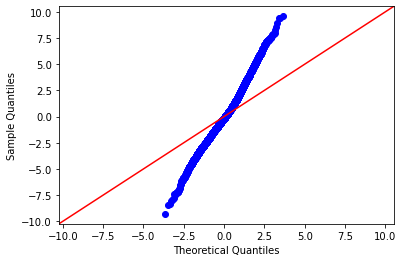

In [21]:
met = [DecisionTreeRegressor(max_depth=7,random_state=1), RandomForestRegressor(max_depth=14,random_state=1), SVR(), linear_model.LinearRegression()]
m = ['Decision Tree','Random Forest','SVR', "Regresión Lineal Mult."]
plots = 1
for i in range (0,len(met)):
    met[i].fit(x_train,y_train) # Se entrena el modelo
    y_pred=met[i].predict(x_test) #Se realiza una predicción
    
    rms = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
    print ('Método: ',i+1,met[i])
    print ('El error cuadrático medio es:',rms)
    scorer = r2_score(y_test,y_pred) 
    print ('r2_score: ',scorer)
    scores = cross_val_score(met[i], x_train, y_train, cv=10)
    s = np.mean(np.sqrt(abs(scores)))
    print ('Cross-Validation: ',s)
    print ('\n')
    
    plt.figure(figsize=(15,50))
    plt.subplot(12,3,plots)
    plt.hist(y_pred,alpha=0.4,color='green')
    plt.hist(y_test,alpha=0.4)
    a = m[i]
    plt.title(a)
    plots = plots + 1
    
    residuos = y_test - y_pred
    plt.subplot(12,3,plots)
    plt.hist(residuos,alpha=0.4)
    plt.title("Distribución de residuos: " + m[i])
    plots = plots + 1
    
    plt.subplot(12,3,plots)
    plt.boxplot(residuos,vert=True,patch_artist=True);
    plt.title("Distribución de residuos: " + m[i]);
    plots = plots + 1
    
    sm.qqplot(residuos, line ='45') 
    py.show()

Se realiza la construcción, entrenamiento y evaluación de cada modelo. Logramos observar que los 4 modelos tienen una puntuación mayor al 0.5, lo que quiere decir que son buenos pero no cuentan con una precisión bastante buena para ser usados en producción. El modelo que mejor resultado nos dio fue el Random Forest con 0.68. 

Cabe resaltar que la distribución de los residuos entre los datos reales y la predición es normal lo que indica que los modelos son buenos pero con el grafico de cajas y el gafico QQ se observan que no son tan preciso.

In [32]:
# Predicciones
random = np.random.choice(range(0,x_test.shape[0]))
for i in range(0, len(met)):
    pred1 = met[i].predict(np.array([x_test.iloc[random]]))[0]
    print("Modelo: ", met[i])
    print("Datos de entrada:\n", x_test.iloc[random])
    print("Temperatura real: ", y_test.iloc[random])
    print("Temperatura predecida: ", pred1)
    print("\n===============================\n")

Modelo:  DecisionTreeRegressor(max_depth=7, random_state=1)
Datos de entrada:
 pm25     19.0000
no2      18.6532
ozono     0.7000
no       25.5631
hora      2.0000
Name: 31669, dtype: float64
Temperatura real:  17.4378
Temperatura predecida:  20.32234416666665


Modelo:  RandomForestRegressor(max_depth=14, random_state=1)
Datos de entrada:
 pm25     19.0000
no2      18.6532
ozono     0.7000
no       25.5631
hora      2.0000
Name: 31669, dtype: float64
Temperatura real:  17.4378
Temperatura predecida:  19.573771895858147


Modelo:  SVR()
Datos de entrada:
 pm25     19.0000
no2      18.6532
ozono     0.7000
no       25.5631
hora      2.0000
Name: 31669, dtype: float64
Temperatura real:  17.4378
Temperatura predecida:  20.357679298495736


Modelo:  LinearRegression()
Datos de entrada:
 pm25     19.0000
no2      18.6532
ozono     0.7000
no       25.5631
hora      2.0000
Name: 31669, dtype: float64
Temperatura real:  17.4378
Temperatura predecida:  20.71553273295327




In [34]:
# prueba real
prueba = pd.DataFrame({
    "pm25": [18.0],
    "no2": [5.3097],
    "ozono": [33.5],
    "nox": [7.6488],
    "hora": [13]
})

for i in range(0, len(met)):
    pred1 = met[i].predict(np.array(prueba))[0]
    print("Modelo: ", met[i])
    print("Temperatura real: 28.634")
    print("Temperatura predecida: ", pred1)
    print("\n===============================\n")

Modelo:  DecisionTreeRegressor(max_depth=7, random_state=1)
Temperatura real: 28.634
Temperatura predecida:  29.231886893203885


Modelo:  RandomForestRegressor(max_depth=14, random_state=1)
Temperatura real: 28.634
Temperatura predecida:  29.3195846334982


Modelo:  SVR()
Temperatura real: 28.634
Temperatura predecida:  28.24255320393529


Modelo:  LinearRegression()
Temperatura real: 28.634
Temperatura predecida:  26.16913119519144




<a id="section5.3"></a>
## <font color="#004D7F" size=5>Red neuronal artificial (ANN)</font>

In [36]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (5,)),
    tf.keras.layers.Dense(1, activation='softplus'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(1, activation='softplus')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 6         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


In [37]:
#Optimizador
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

#Compilar modelo
model.compile(optimizer=opt,
               loss='mean_squared_error',
               metrics=['mean_squared_error'])

#Entrenar el modelo
modelfit = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=60)

Epoch 1/60
753/753 [==============================] - 1s 1ms/step - loss: 512.9873 - mean_squared_error: 512.9873 - val_loss: 470.0498 - val_mean_squared_error: 470.0498
Epoch 2/60
753/753 [==============================] - 1s 965us/step - loss: 135.8128 - mean_squared_error: 135.8128 - val_loss: 56.7459 - val_mean_squared_error: 56.7459
Epoch 3/60
753/753 [==============================] - 1s 962us/step - loss: 49.5804 - mean_squared_error: 49.5804 - val_loss: 43.2594 - val_mean_squared_error: 43.2594
Epoch 4/60
753/753 [==============================] - 1s 964us/step - loss: 40.2121 - mean_squared_error: 40.2121 - val_loss: 37.0161 - val_mean_squared_error: 37.0161
Epoch 5/60
753/753 [==============================] - 1s 982us/step - loss: 34.8103 - mean_squared_error: 34.8103 - val_loss: 32.4972 - val_mean_squared_error: 32.4972
Epoch 6/60
753/753 [==============================] - 1s 960us/step - loss: 30.1651 - mean_squared_error: 30.1651 - val_loss: 28.0205 - val_mean_squared_err

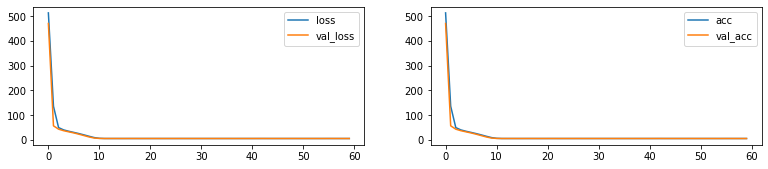

In [38]:
fig=plt.figure(figsize=(70, 30))

fig.add_subplot(10, 10, 1)
plt.plot(modelfit.history['loss'], label='loss')
plt.plot(modelfit.history['val_loss'], label='val_loss')
plt.legend()

fig.add_subplot(10, 10, 2)
plt.plot(modelfit.history['mean_squared_error'], label='acc')
plt.plot(modelfit.history['val_mean_squared_error'], label='val_acc')
plt.legend()

plt.show()

Text(0.5, 1.0, 'Distribución de residuos')

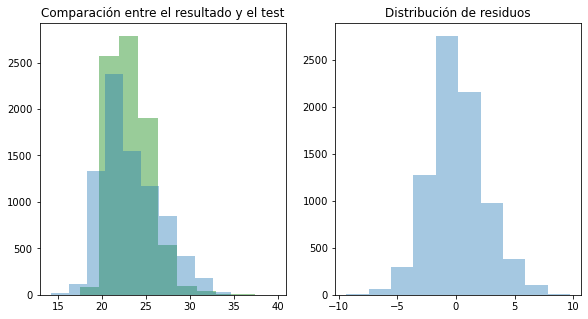

In [39]:
y_result = model.predict(x_test)[:,0]
residuos = y_test - y_result

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.hist(y_result,alpha=0.4,color='green')
plt.hist(y_test,alpha=0.4)
plt.title("Comparación entre el resultado y el test")

plt.subplot(1,3,2)
plt.hist(residuos,alpha=0.4)
plt.title("Distribución de residuos")

In [40]:
model.evaluate(x_test, y_test)

251/251 [==============================] - 0s 649us/step - loss: 5.5534 - mean_squared_error: 5.5534


[5.553393840789795, 5.553393840789795]

In [41]:
print("r2 Score: ", r2_score(y_test, y_result))

r2 Score:  0.47592057007227495


In [43]:
i = np.random.choice(range(0,x_test.shape[0]))
prediction = model.predict(np.array([x_test.iloc[i]]))[0]
print("Datos de entrada:\n", x_test.iloc[i])
print("Temperatura real: ", y_test.iloc[i])
print("Temperatura predecida: ", prediction)

Datos de entrada:
 pm25     17.0000
no2      19.2241
ozono     5.2000
no       22.3033
hora     20.0000
Name: 31426, dtype: float64
Temperatura real:  20.0957
Temperatura predecida:  [22.853853]


In [44]:
prueba = pd.DataFrame({
    "pm25": [18.0],
    "no2": [5.3097],
    "ozono": [33.5],
    "nox": [7.6488],
    "hora": [13]
})
prueba
p1 = model.predict(np.array(prueba))[0]
print("Datos de entrada:\n", prueba)
print("Temperatura real: 28.634")
print("Temperatura predecida: ", p1)


Datos de entrada:
    pm25     no2  ozono     nox  hora
0  18.0  5.3097   33.5  7.6488    13
Temperatura real: 28.634
Temperatura predecida:  [26.198715]


<a id="section6"></a>
## <font color="#004D7F" size=6>Modelos con variables categoricas</font>

Debido a que la precisión de los modelos anteriores con variables continuas no fue bueno, decidimos probar con variables categoricas. Para crear las categorias nos basamos en el rango de temperatura del Aire que nos presenta SIATA. https://siata.gov.co/siata_nuevo/ <img src="imagenes/rango_temperatura.png" alt="Rango de temperatura" align="center">

Nuestra Categoria sera la siguiente:

0. Frio, temperatura menor a 22 °C
1. Medio, temperatura entre 22°C y 26°C
2. Alto, temperatura mayor a 26°C

In [47]:
datosTest = datos.copy()[['pm25', 'no2',  'ozono', 'no', 'hora', 'temperatura']]

for i in range(0,len(datosTest['temperatura'])):
    # BAJA
    if round(datosTest['temperatura'][i]) <= 22:
        datosTest['temperatura'][i] = 0
    # Media
    elif round(datosTest['temperatura'][i]) > 22 and round(datosTest['temperatura'][i]) <= 26:
        datosTest['temperatura'][i] = 1
    # Alta
    elif round(datosTest['temperatura'][i]) > 26:
        datosTest['temperatura'][i] = 2
datosTest['temperatura'] = datosTest['temperatura'].astype(np.int64)

print(datosTest.dtypes)
datosTest.describe().transpose()

pm25           float64
no2            float64
ozono          float64
no             float64
hora             int64
temperatura      int64
dtype: object


,count,mean,std,min,25%,50%,75%,max
pm25,32098.0,20.818019,13.070837,0.0,11.000000,19.000000,27.000000,128.0000
no2,32098.0,14.525961,8.881023,0.0,8.283775,13.087100,18.623750,94.3757
ozono,32098.0,13.736053,12.422501,0.0,3.618112,10.372500,21.000000,119.4030
no,32098.0,17.192831,22.761418,0.0,3.638825,8.762465,20.364775,345.0050
hora,32098.0,11.527728,6.934806,0.0,6.000000,12.000000,18.000000,23.0000
temperatura,32098.0,0.683002,0.764421,0.0,0.000000,0.000000,1.000000,2.0000


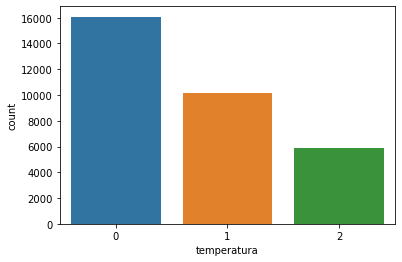

In [48]:
sns.countplot(x='temperatura',data=datosTest); #Gráfica de los datos de salida.

In [49]:
datosEntrada = datosTest[['pm25', 'no2',  'ozono', 'no', 'hora']]
datosSalida = datosTest["temperatura"]
x_train, x_test, y_train, y_test = train_test_split(datosEntrada, datosSalida, test_size=0.25)

<a id="section6.1"></a>
## <font color="#004D7F" size=5>Regresión logistica, Arbol de desiciones, SVM y Random Forest</font>

Método:  1 LogisticRegression()
Accuracy:  0.6573208722741433
Cross-Validation:  0.811745609523534
Confusion_matrix: 
 [[3391  607   38]
 [ 912 1204  375]
 [ 108  710  680]]
Classification_report: 
               precision    recall  f1-score   support

           0       0.77      0.84      0.80      4036
           1       0.48      0.48      0.48      2491
           2       0.62      0.45      0.52      1498

    accuracy                           0.66      8025
   macro avg       0.62      0.59      0.60      8025
weighted avg       0.65      0.66      0.65      8025





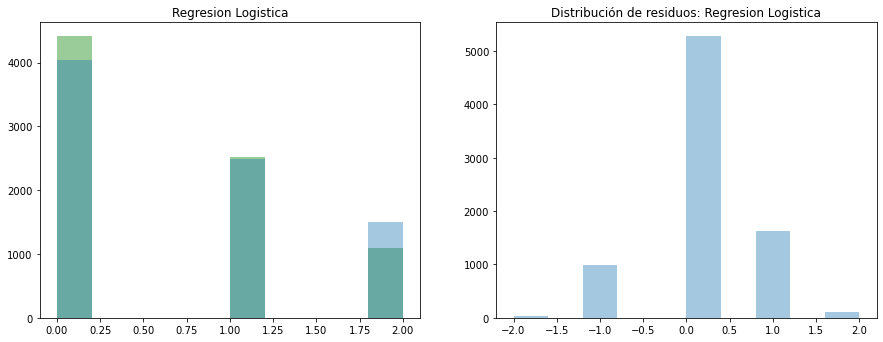

Método:  2 SVC()
Accuracy:  0.7104049844236761
Cross-Validation:  0.8443313480404291
Confusion_matrix: 
 [[3545  469   22]
 [ 766 1331  394]
 [  51  622  825]]
Classification_report: 
               precision    recall  f1-score   support

           0       0.81      0.88      0.84      4036
           1       0.55      0.53      0.54      2491
           2       0.66      0.55      0.60      1498

    accuracy                           0.71      8025
   macro avg       0.68      0.65      0.66      8025
weighted avg       0.70      0.71      0.71      8025





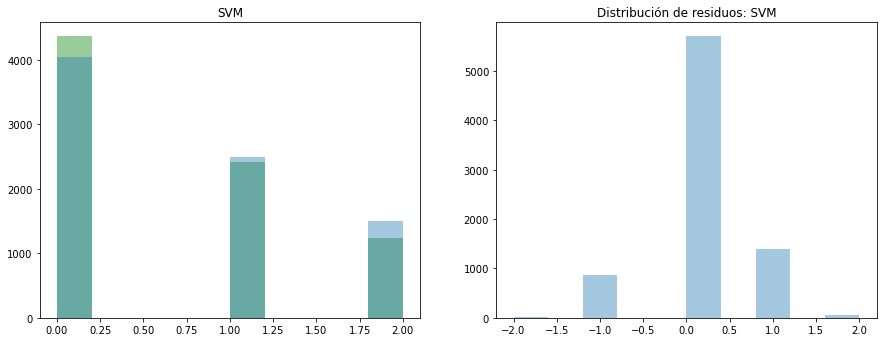

Método:  3 DecisionTreeClassifier(max_depth=18, random_state=1)
Accuracy:  0.6695327102803739
Cross-Validation:  0.8175918784751943
Confusion_matrix: 
 [[3235  712   89]
 [ 702 1301  488]
 [  72  589  837]]
Classification_report: 
               precision    recall  f1-score   support

           0       0.81      0.80      0.80      4036
           1       0.50      0.52      0.51      2491
           2       0.59      0.56      0.57      1498

    accuracy                           0.67      8025
   macro avg       0.63      0.63      0.63      8025
weighted avg       0.67      0.67      0.67      8025





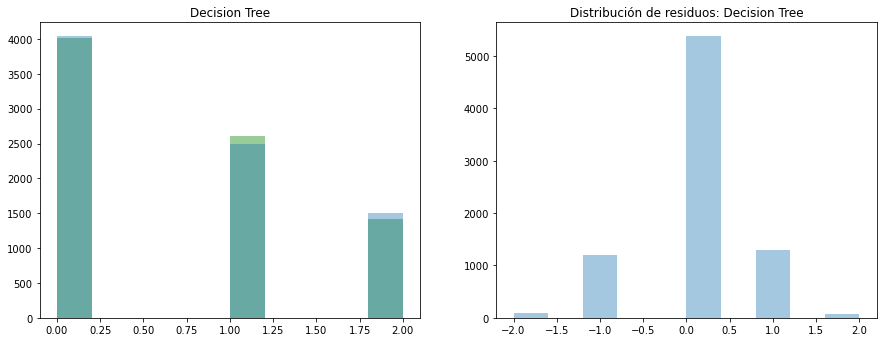

Método:  4 RandomForestClassifier(max_depth=26, random_state=1)
Accuracy:  0.7297196261682243
Cross-Validation:  0.8557276513140447
Confusion_matrix: 
 [[3476  510   50]
 [ 593 1428  470]
 [  29  517  952]]
Classification_report: 
               precision    recall  f1-score   support

           0       0.85      0.86      0.85      4036
           1       0.58      0.57      0.58      2491
           2       0.65      0.64      0.64      1498

    accuracy                           0.73      8025
   macro avg       0.69      0.69      0.69      8025
weighted avg       0.73      0.73      0.73      8025





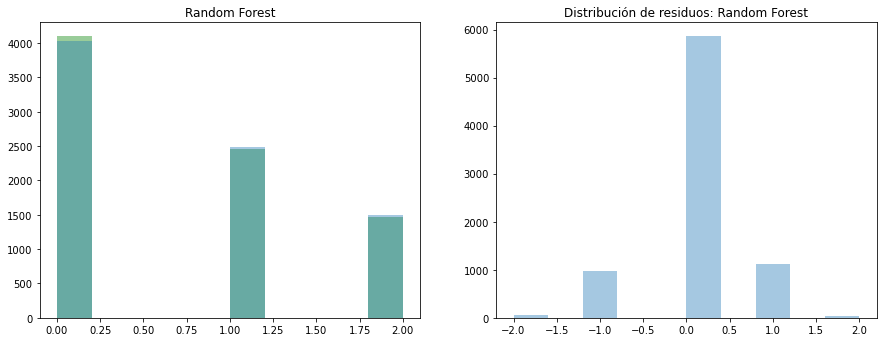

In [50]:
met = [LogisticRegression(),SVC(),DecisionTreeClassifier(max_depth=18, random_state=1),
       RandomForestClassifier(max_depth=26,random_state=1)]
m = ['Regresion Logistica','SVM','Decision Tree','Random Forest']
plots = 1
for i in range (0,len(met)):
    met[i].fit(x_train,y_train) # Se entrena el modelo
    y_pred=met[i].predict(x_test) #Se realiza una predicción

    print ('Método: ',i+1,met[i])
    scorer2 = accuracy_score(y_test, y_pred) 
    print ('Accuracy: ',scorer2)
    scores2 = cross_val_score(met[i], x_train, y_train, cv=10)
    s2 = np.mean(np.sqrt(abs(scores2)))
    print ('Cross-Validation: ',s2)
    print('Confusion_matrix: \n',confusion_matrix(y_test, y_pred))
    print('Classification_report: \n',classification_report(y_test,y_pred))
    print ('\n')
    
    plt.figure(figsize=(15,25))
    plt.subplot(4,2,plots)
    plt.hist(y_pred,alpha=0.4,color='green')
    plt.hist(y_test,alpha=0.4)
    a = m[i]
    plt.title(a)
    plots = plots + 1
    
    residuos = y_test - y_pred
    plt.subplot(4,2,plots)
    plt.hist(residuos,alpha=0.4)
    plt.title("Distribución de residuos: " + m[i])
    plots = plots + 1
    plt.show()

In [56]:
# Predicciones
random = np.random.choice(range(0,x_test.shape[0]))
for i in range(0, len(met)):
    pred1 = met[i].predict(np.array([x_test.iloc[random]]))[0]
    print("Modelo: ", met[i])
    print("Datos de entrada:\n", x_test.iloc[random])
    print("Temperatura real: ", y_test.iloc[random])
    print("Temperatura predecida: ", pred1)
    print("\n===============================\n")

Modelo:  LogisticRegression()
Datos de entrada:
 pm25     20.0000
no2      19.5965
ozono     7.1000
no        6.4641
hora     21.0000
Name: 18729, dtype: float64
Temperatura real:  1
Temperatura predecida:  0


Modelo:  SVC()
Datos de entrada:
 pm25     20.0000
no2      19.5965
ozono     7.1000
no        6.4641
hora     21.0000
Name: 18729, dtype: float64
Temperatura real:  1
Temperatura predecida:  0


Modelo:  DecisionTreeClassifier(max_depth=18, random_state=1)
Datos de entrada:
 pm25     20.0000
no2      19.5965
ozono     7.1000
no        6.4641
hora     21.0000
Name: 18729, dtype: float64
Temperatura real:  1
Temperatura predecida:  1


Modelo:  RandomForestClassifier(max_depth=26, random_state=1)
Datos de entrada:
 pm25     20.0000
no2      19.5965
ozono     7.1000
no        6.4641
hora     21.0000
Name: 18729, dtype: float64
Temperatura real:  1
Temperatura predecida:  1




<a id="section6.2"></a>
## <font color="#004D7F" size=5>Red Neuronal Artificial (ANN)</font>

In [57]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (5,)),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(30, activation='softmax'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(25, activation='softmax'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_4 (Dense)              (None, 25)                150       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                780       
_________________________________________________________________
dense_6 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_7 (Dense)              (None, 25)                775       
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 78        
Total params: 2,743
Trainable params: 2,743
Non-trainable params: 0
____________________________________________________

In [58]:
#Optimizador 
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

#Compilar modelo
model.compile(optimizer=opt,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

#Entrenar el modelo
modelfit = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=150)

Epoch 1/150
753/753 [==============================] - 1s 1ms/step - loss: 0.8891 - accuracy: 0.5667 - val_loss: 0.7662 - val_accuracy: 0.6409
Epoch 2/150
753/753 [==============================] - 1s 1ms/step - loss: 0.7399 - accuracy: 0.6561 - val_loss: 0.7033 - val_accuracy: 0.6847
Epoch 3/150
753/753 [==============================] - 1s 1ms/step - loss: 0.6924 - accuracy: 0.6902 - val_loss: 0.6781 - val_accuracy: 0.6973
Epoch 4/150
753/753 [==============================] - 1s 1ms/step - loss: 0.6722 - accuracy: 0.6965 - val_loss: 0.6563 - val_accuracy: 0.7049
Epoch 5/150
753/753 [==============================] - 1s 1ms/step - loss: 0.6597 - accuracy: 0.7007 - val_loss: 0.6518 - val_accuracy: 0.7055
Epoch 6/150
753/753 [==============================] - 1s 1ms/step - loss: 0.6510 - accuracy: 0.7057 - val_loss: 0.6392 - val_accuracy: 0.7088
Epoch 7/150
753/753 [==============================] - 1s 1ms/step - loss: 0.6443 - accuracy: 0.7080 - val_loss: 0.6364 - val_accuracy: 0.7156

Epoch 58/150
753/753 [==============================] - 1s 1ms/step - loss: 0.5999 - accuracy: 0.7261 - val_loss: 0.6108 - val_accuracy: 0.7158
Epoch 59/150
753/753 [==============================] - 1s 1ms/step - loss: 0.6013 - accuracy: 0.7262 - val_loss: 0.5938 - val_accuracy: 0.7286
Epoch 60/150
753/753 [==============================] - 1s 1ms/step - loss: 0.6001 - accuracy: 0.7237 - val_loss: 0.5918 - val_accuracy: 0.7257
Epoch 61/150
753/753 [==============================] - 1s 1ms/step - loss: 0.5985 - accuracy: 0.7265 - val_loss: 0.5990 - val_accuracy: 0.7254
Epoch 62/150
753/753 [==============================] - 1s 1ms/step - loss: 0.6003 - accuracy: 0.7249 - val_loss: 0.5985 - val_accuracy: 0.7257
Epoch 63/150
753/753 [==============================] - 1s 1ms/step - loss: 0.5997 - accuracy: 0.7259 - val_loss: 0.5996 - val_accuracy: 0.7216
Epoch 64/150
753/753 [==============================] - 1s 1ms/step - loss: 0.5997 - accuracy: 0.7252 - val_loss: 0.6108 - val_accuracy:

Epoch 115/150
753/753 [==============================] - 1s 1ms/step - loss: 0.5886 - accuracy: 0.7347 - val_loss: 0.5851 - val_accuracy: 0.7331
Epoch 116/150
753/753 [==============================] - 1s 1ms/step - loss: 0.5880 - accuracy: 0.7340 - val_loss: 0.5899 - val_accuracy: 0.7281
Epoch 117/150
753/753 [==============================] - 1s 1ms/step - loss: 0.5901 - accuracy: 0.7334 - val_loss: 0.5893 - val_accuracy: 0.7285
Epoch 118/150
753/753 [==============================] - 1s 1ms/step - loss: 0.5894 - accuracy: 0.7311 - val_loss: 0.5895 - val_accuracy: 0.7333
Epoch 119/150
753/753 [==============================] - 1s 1ms/step - loss: 0.5891 - accuracy: 0.7319 - val_loss: 0.5868 - val_accuracy: 0.7293
Epoch 120/150
753/753 [==============================] - 1s 1ms/step - loss: 0.5882 - accuracy: 0.7348 - val_loss: 0.5855 - val_accuracy: 0.7345
Epoch 121/150
753/753 [==============================] - 1s 1ms/step - loss: 0.5901 - accuracy: 0.7323 - val_loss: 0.6020 - val_ac

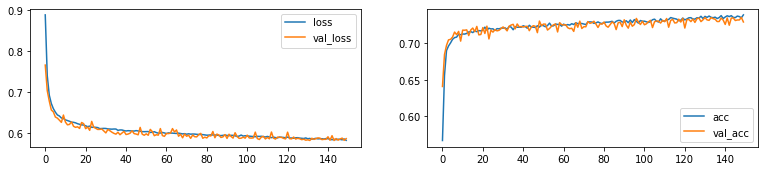

In [59]:
fig=plt.figure(figsize=(70, 30))

fig.add_subplot(10, 10, 1)
plt.plot(modelfit.history['loss'], label='loss')
plt.plot(modelfit.history['val_loss'], label='val_loss')
plt.legend()

fig.add_subplot(10, 10, 2)
plt.plot(modelfit.history['accuracy'], label='acc')
plt.plot(modelfit.history['val_accuracy'], label='val_acc')
plt.legend()

plt.show()

In [60]:
print(model.evaluate(x_test, y_test))

251/251 [==============================] - 0s 784us/step - loss: 0.5861 - accuracy: 0.7295
[0.5861299633979797, 0.729470431804657]


Text(0.5, 1.0, 'Distribución de residuos')

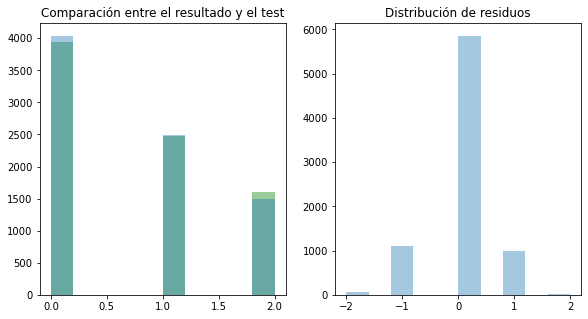

In [61]:
y_result = model.predict(x_test)
y_result = y_result.argmax(axis=1)
residuos = y_test - y_result

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.hist(y_result,alpha=0.4,color='green')
plt.hist(y_test,alpha=0.4)
plt.title("Comparación entre el resultado y el test")

plt.subplot(1,3,2)
plt.hist(residuos,alpha=0.4)
plt.title("Distribución de residuos")

In [76]:
i = np.random.choice(range(0,x_test.shape[0]))
prediction = model.predict(np.array([x_test.iloc[i]])).argmax(axis=1)[0]
print("Datos de entrada:\n", x_test.iloc[i])
print("Rango de temperatura real: ", y_test.iloc[i])
print("Rango de temperatura predecida", prediction)

Datos de entrada:
 pm25     13.0000
no2       7.5740
ozono    13.9000
no       10.6007
hora      9.0000
Name: 8716, dtype: float64
Rango de temperatura real:  1
Rango de temperatura predecida 1


<a href="Paso 3 - Carga de la temperatura.html" target="_self">← Regresar al Paso 3 - Carga de la temperatura</a>